In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import numpy as np
import pandas as pd
from pathlib import Path
from collections import Counter
import seaborn as sns
from matplotlib import pyplot as plt

In [3]:
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import confusion_matrix
from imblearn.metrics import classification_report_imbalanced

In [4]:
# Load the data
file_path = Path('Diabetes dataset_Group12.csv')
df = pd.read_csv(file_path)
df = df.drop(columns = "ID")
new_df = df.drop(columns = "Label")
new_df.head()

,FPG,HOMA_IR,Total_TAG,2hr_OGTT,T_CE,T_TAG,T_DAG,T_FFA,T_PC,T_PE,...,total DMA,alpha-AAA,Creatinine,Kynurenine,Met-SO,t4-OH-Pro,Putrescine,Serotonin,Spermidine,Taurine
0,6.426266,2.336573,5.781363,6.491854,12.09865,10.273816,4.086167,9.443437,10.80714,7.199930,...,0.111588,1.874979,6.710942,2.394366,-5.852678,4.214117,-3.462398,-1.018531,-1.642998,6.532927
1,6.741468,3.109857,7.906891,7.451211,12.09865,10.807138,4.907486,8.901539,10.27382,7.402848,...,-0.692381,-0.488355,6.008138,0.756260,-3.400239,2.677591,-3.313604,0.813043,-2.012510,7.612722
2,6.672426,3.621295,7.000001,6.942515,12.09865,10.273816,4.379796,8.802699,10.80714,6.759415,...,-0.032965,0.487615,6.008138,1.285267,-4.594876,3.496043,-7.375598,-1.504665,-2.644530,6.185453
3,6.491854,1.563326,7.011228,6.629358,12.09865,10.273816,4.281923,8.522484,10.80714,6.948541,...,0.226960,0.382100,6.440727,2.198089,-2.392424,4.504812,-3.638916,-2.520678,-2.473015,5.894638
4,6.539160,1.997820,6.285404,6.954197,12.09865,9.228706,3.965879,8.901539,10.80714,7.082903,...,1.018463,0.024295,6.532927,2.766317,-8.606643,3.550989,-2.483951,-1.491908,-1.194648,6.267509


In [5]:
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()
df['Label'] = df['Label'].astype(str)
df['Label'] = encoder.fit_transform(df['Label'])

<AxesSubplot:>

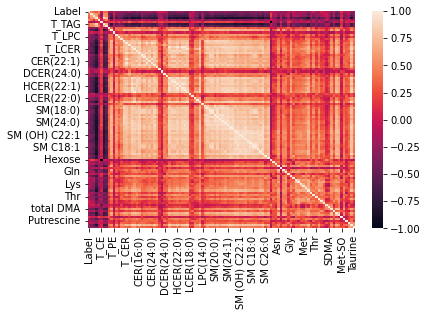

In [6]:
#heatmap of correlation
sns.heatmap(df.corr())

In [23]:
def get_high_corr_df(df, positive_threshold=0.2):
    corr = df.corr().stack().reset_index().drop_duplicates()
    corr.columns = ['FEATURE_1', 'FEATURE_2', 'CORRELATION']
    high_corr = corr[((corr['FEATURE_1'] != corr['FEATURE_2']) & ((corr['CORRELATION'] >= positive_threshold) | (corr['CORRELATION'] <= positive_threshold*-1)))]
    return high_corr

In [24]:
high_corr = get_high_corr_df(df)
high_corr[(high_corr['FEATURE_1'] == 'Label')]

,FEATURE_1,FEATURE_2,CORRELATION
1,Label,FPG,0.434875
2,Label,HOMA_IR,0.355802
3,Label,Total_TAG,0.298528
4,Label,2hr_OGTT,0.542159
6,Label,T_TAG,0.380311
...,...,...,...
96,Label,total DMA,-0.304557
98,Label,Creatinine,-0.415123
99,Label,Kynurenine,-0.347334
104,Label,Spermidine,-0.263555


In [25]:
# Create our features
X = df[high_corr['FEATURE_2'].unique()]

# Create our target
y = df["Label"]

In [26]:
X.describe()

,FPG,HOMA_IR,Total_TAG,2hr_OGTT,T_TAG,T_DAG,T_PC,T_PI,T_LPC,T_LPE,...,His,Pro,Tyr,Val,SDMA,alpha-AAA,Serotonin,Met-SO,ADMA,T_PE
count,58.000000,58.000000,58.000000,58.000000,58.000000,58.000000,58.000000,58.000000,58.000000,58.000000,...,58.000000,58.000000,58.000000,58.000000,58.000000,58.000000,58.000000,58.000000,58.000000,58.000000
mean,6.614549,2.701736,6.844076,6.926155,10.319602,4.323889,10.669212,3.518789,7.667554,2.233816,...,6.850368,7.811441,6.355285,7.873123,-0.911963,0.079763,-2.809970,-3.658187,-1.883678,7.054732
std,0.139946,0.923355,0.822207,0.336438,0.613956,0.329148,0.235568,0.327468,0.295845,0.301778,...,0.452913,0.349122,0.465887,0.471584,2.262527,0.865511,2.188667,2.969190,2.395359,0.295159
min,6.339851,0.706960,5.584967,5.882646,9.004653,3.531287,10.273820,2.713004,6.948541,1.391305,...,5.741015,7.082903,5.171766,6.399914,-10.044283,-2.973741,-10.044283,-10.044284,-9.285779,6.440727
25%,6.515637,2.153218,6.228442,6.703892,10.273816,4.090292,10.407150,3.315533,7.450789,2.106100,...,6.532927,7.522151,6.073657,7.612722,-1.004203,-0.344862,-3.881660,-5.841102,-1.937343,6.849232
50%,6.607312,2.538648,6.761414,6.906891,10.273816,4.331543,10.807140,3.531557,7.661110,2.279128,...,6.849629,7.889900,6.399914,7.862571,-0.263703,0.150635,-2.407604,-2.782335,-1.158229,7.043002
75%,6.700441,3.319494,7.266787,7.199572,10.673808,4.568362,10.807140,3.737528,7.835243,2.422984,...,7.179674,8.042766,6.666040,8.234621,0.196751,0.473564,-1.466755,-1.191318,-0.465523,7.243204
max,6.965785,5.093344,8.774787,7.507795,11.408379,4.907486,10.807140,4.214117,8.522484,2.816563,...,7.769827,8.602744,7.322323,8.802699,2.898183,2.141128,0.972990,1.045463,0.392081,7.769827


In [27]:
# Check the balance of our target values
y.value_counts()

1    30
0    28
Name: Label, dtype: int64

In [28]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1, stratify=y)

In [29]:
# Resample the training data with the BalancedRandomForestClassifier
from imblearn.ensemble import BalancedRandomForestClassifier
randomforest = BalancedRandomForestClassifier(n_estimators = 100, max_depth= 7, max_features='auto', random_state=1)
resampled = randomforest.fit(X_train, y_train)

In [30]:
# Calculated the balanced accuracy score
from sklearn.metrics import balanced_accuracy_score
yprediction = resampled.predict(X_test)
balanced_accuracy_score(y_test, yprediction)

0.7946428571428572

In [31]:
# Display the confusion matrix
from sklearn.metrics import confusion_matrix
matrix = confusion_matrix(y_test, yprediction)
print(matrix)

[[5 2]
 [1 7]]


In [32]:
# Print the imbalanced classification report
from imblearn.metrics import classification_report_imbalanced
report = classification_report_imbalanced(y_test, yprediction)
print(report)

                   pre       rec       spe        f1       geo       iba       sup

          0       0.83      0.71      0.88      0.77      0.79      0.61         7
          1       0.78      0.88      0.71      0.82      0.79      0.64         8

avg / total       0.80      0.80      0.79      0.80      0.79      0.63        15



In [33]:
# List the features sorted in descending order by feature importance
feature_names = X.columns.drop('Label')
sorted(zip(randomforest.feature_importances_, feature_names), reverse=True)

[(0.20264225613049053, 'T_CE'),
 (0.053584342807609084, '2hr_OGTT'),
 (0.030649538484123322, 'Taurine'),
 (0.030071039188412727, 'SM C20:2'),
 (0.027832763624799972, 'SM(20:1)'),
 (0.02727530965141624, 'Kynurenine'),
 (0.018540134084412758, 'SM(18:0)'),
 (0.017681381637450994, 'T_LCER'),
 (0.017035026755995327, 'HCER(18:0)'),
 (0.016520071010461688, 'CER(24:0)'),
 (0.016031536615822562, 'SM C18:0'),
 (0.015079930982882742, 'HCER(16:0)'),
 (0.014971079053716375, 'alpha-AAA'),
 (0.014050964733257102, 'SM(26:1)'),
 (0.012708760537707907, 'SM(22:1)'),
 (0.011922348484848484, 'CER(24:1)'),
 (0.011737700779053223, 'T_DAG'),
 (0.011220306202504256, 't4-OH-Pro'),
 (0.010840857761949096, 'Asp'),
 (0.010345064219211726, 'SM C24:0'),
 (0.010238100541209393, 'SM C24:1'),
 (0.010141958963348114, 'SM(16:0)'),
 (0.010109884226900265, 'LCER(22:0)'),
 (0.010078442368102443, 'ADMA'),
 (0.010021212982338303, 'Lys'),
 (0.00973024669652959, 'SM(24:1)'),
 (0.009272761552173317, 'T_SM'),
 (0.0091632545834548

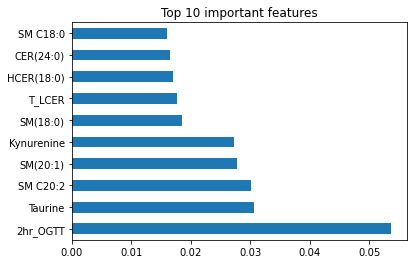

In [34]:
feat_importances = pd.Series(randomforest.feature_importances_, index = X.columns)
feat_importances.nlargest(11).drop('Label').plot(kind='barh')
plt.title("Top 10 important features")
plt.show()

In [35]:
def find_top_10_feature(df):
    feat = []
    feat_name = X.columns
    feat_importances = pd.Series(randomforest.feature_importances_, index=X.columns)
    for f in feat_importances.nlargest(11).keys():
        feat.append(f)
    new_df = df[feat]
    return new_df

In [36]:
top_10_parameters = find_top_10_feature(df)
top_10_parameters

,Label,2hr_OGTT,Taurine,SM C20:2,SM(20:1),Kynurenine,SM(18:0),T_LCER,HCER(18:0),CER(24:0),SM C18:0
0,0,6.491854,6.532927,0.066374,3.311127,2.394366,5.236556,2.522395,-2.419750,2.115788,5.017517
1,0,7.451211,7.612722,-0.393734,2.616889,0.756260,4.262670,1.500078,-4.759624,0.382100,4.424867
2,0,6.942515,6.185453,-0.398748,3.067994,1.285267,4.649132,0.990307,-4.411737,0.791187,4.746527
3,0,6.629358,5.894638,0.047862,2.863653,2.198089,4.530147,1.756906,-4.014523,0.922508,4.784064
4,0,6.954197,6.267509,1.133249,3.260484,2.766317,4.649132,2.079468,-3.462398,1.687269,5.390962
5,0,7.011228,5.171766,-0.543613,2.616889,1.874979,4.151145,0.904555,-4.411737,1.490175,4.069262
6,0,5.882646,6.849232,0.236302,3.029029,2.333384,4.553033,1.729531,-4.453161,1.972979,4.807594
7,0,6.409392,4.069262,-0.083298,3.051256,2.297289,5.017517,2.029526,-3.614449,1.542498,4.886812
8,0,6.906891,6.008138,-0.347071,2.878295,1.528768,4.735043,1.972979,-3.769828,1.452535,4.530147
9,0,6.741468,4.402749,0.236302,2.938209,2.480864,4.667556,2.451663,-3.666074,1.480415,4.856116


In [37]:
top_10_parameters.to_csv('top_10_parameters.csv')